#Imports

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

#Data load

In [2]:
df_sessions = pd.read_csv('/content/drive/MyDrive/ga_sessions.csv', low_memory=False).drop(columns=['device_model',
                                                                                      'utm_keyword', 'device_os',
                                                                                      'client_id'])

In [3]:
df_hits = pd.read_csv('/content/drive/MyDrive/Копия ga_hits.csv').drop(columns=['event_value', 'hit_time', 'hit_referer',
                                                            'event_label', 'hit_date', 'hit_number',
                                                            'hit_type', 'hit_page_path', 'event_category'])

In [4]:
target_list = ['sub_car_claim_click', 'sub_car_claim_submit_click',
               'sub_open_dialog_click', 'sub_custom_question_submit_click',
               'sub_call_number_click', 'sub_callback_submit_click',
               'sub_submit_success', 'sub_car_request_submit_click']
df_hits['target'] = df_hits['event_action'].apply(lambda x: 1 if x in target_list else 0)
df_hits = df_hits.drop(columns=['event_action'])
group = df_hits.groupby('session_id').max()

df = pd.merge(left=group, right=df_sessions, on='session_id', how='inner')
df

,session_id,target,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
0,1000009318903347362.1632663668.1632663668,0,2021-09-26,16:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,Samsung,412x869,Chrome,Russia,Gelendzhik
1,1000010177899156286.1635013443.1635013443,0,2021-10-23,21:24:03,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Samsung Internet,Russia,Voronezh
2,1000013386240115915.1635402956.1635402956,0,2021-10-28,09:35:56,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,412x846,Chrome,Russia,Cherkessk
3,1000017303238376207.1623489300.1623489300,0,2021-06-12,12:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Realme,360x780,Chrome,Russia,Irkutsk
4,1000020580299877109.1624943350.1624943350,0,2021-06-29,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,414x736,Safari,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732261,999960188766601545.1626816843.1626816843,0,2021-07-21,00:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,dUuXlWzvmhDSyclWRhNP,mobile,Huawei,360x780,Chrome,Russia,Moscow
1732262,99996598443387715.1626811203.1626811203,0,2021-07-20,23:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x667,Safari,Russia,Saint Petersburg
1732263,999966717128502952.1638428330.1638428330,0,2021-12-02,09:58:50,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Xiaomi,393x873,Chrome,Russia,Nizhny Novgorod
1732264,999988617151873171.1623556243.1623556243,0,2021-06-13,06:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,412x732,Samsung Internet,Russia,Chelyabinsk


#Data Preparation

In [5]:
df.device_brand = df.device_brand.apply(
    lambda x: 'other' if x == '(not set)' else x
    )

df['device_browser'] = df['device_browser'].apply(
    lambda x: 'other' if x == '(not set)' else x
    )

df['utm_medium'] = df['utm_medium'].apply(
    lambda x:'other' if (x == '(none)') | (x == '(not set)') else x
    )

df['device_screen_resolution'] = df['device_screen_resolution'].apply(
    lambda x: df.device_screen_resolution.mode()[0] if x == '(not set)' else x
    )

In [6]:
df = df.fillna({'utm_source': df.utm_source.mode()[0],
                'utm_campaign': df.utm_campaign.mode()[0],
                'utm_adcontent': df.utm_adcontent.mode()[0],
                'device_brand': df.device_brand.mode()[0]})

In [7]:
df.isna().sum()

session_id                  0
target                      0
visit_date                  0
visit_time                  0
visit_number                0
utm_source                  0
utm_medium                  0
utm_campaign                0
utm_adcontent               0
device_category             0
device_brand                0
device_screen_resolution    0
device_browser              0
geo_country                 0
geo_city                    0
dtype: int64

#Feature engineering

In [8]:
# Добаление признаков day_of_week и is_night
df.visit_date = pd.to_datetime(df.visit_date, utc=True)
df['day_of_week'] = df.visit_date.dt.weekday

df['visit_hour'] = df['visit_time'].apply(lambda x: x.split(':')[0])
df['visit_hour'] = pd.to_numeric(df.visit_hour)
df['is_night'] = df['visit_hour'].apply(lambda x: 1 if 6 < x < 22 else 0)

In [9]:
# Добаление признака screen_resolution_sqr
df['screen_resolution_X'] = df['device_screen_resolution'].apply(
    lambda x: x.split('x')[0]
    )

df['screen_resolution_Y'] = df['device_screen_resolution'].apply(
    lambda x: x.split('x')[1]
    )

df.screen_resolution_X = df.screen_resolution_X.astype(int)
df.screen_resolution_Y = df.screen_resolution_Y.astype(int)

df['screen_resolution_sqr'] = df.screen_resolution_X * df.screen_resolution_Y
df = df.drop(columns=['screen_resolution_X', 'screen_resolution_Y'])

In [10]:
# Добаление признака на основе георасположения
df['geo_russia'] = df['geo_country'].apply(lambda x: 1 if x == 'Russia' else 0)

df['geo_city_1'] = df.geo_city.apply(lambda x: 1 if x == ('Moscow' or 'Saint Petersburg') else 0)

df['geo_cat'] = df.geo_city_1 + df.geo_russia

In [11]:
# Удаление преобразованных признаков
columns_for_drop = ['visit_date', 'visit_time', 'device_screen_resolution',
                        'geo_country', 'geo_city', 'geo_russia', 'geo_city_1', 'visit_hour']

df = df.drop(columns=columns_for_drop)

#Data visualisation

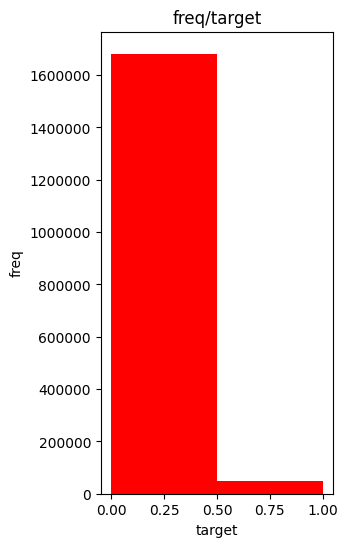

In [62]:
fig, ax = plt.subplots(figsize=(3,6))
ax.hist(df.target, color='r', bins=2)
ax.set_xlabel('target')
ax.set_ylabel('freq')
ax.set_title('freq/target')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Выборки несбалансированы

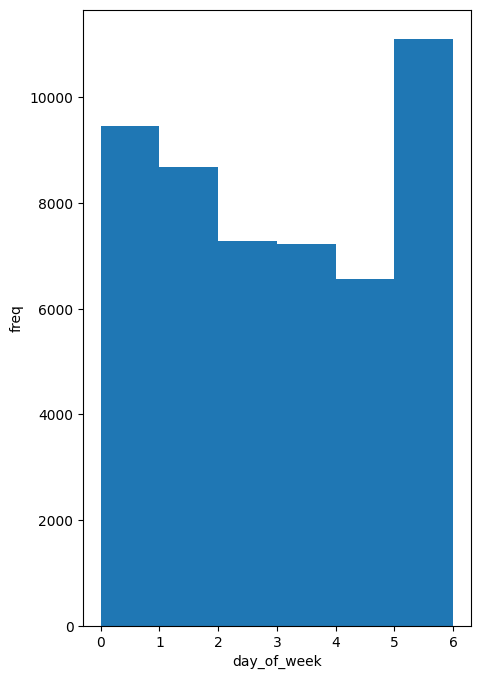

In [63]:
Sfig, ax= plt.subplots(figsize=(5,8))
fig.suptitle('Распределение целевого действия по дням недели')
ax.hist(df.day_of_week[df.target == 1], bins=6)
ax.set_xlabel('day_of_week')
ax.set_ylabel('freq')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

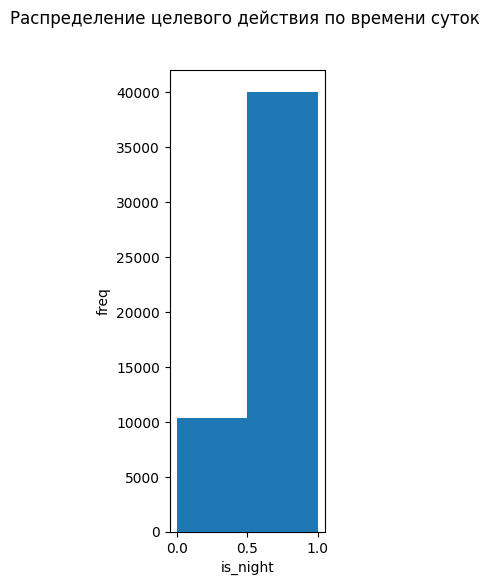

In [64]:
fig, ax= plt.subplots(figsize=(2,6))
fig.suptitle('Распределение целевого действия по времени суток')
ax.hist(df.is_night[df.target == 1], bins=2)
ax.set_xlabel('is_night')
ax.set_ylabel('freq')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

<ipython-input-65-fe43fffaf13b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True)


<Axes: >

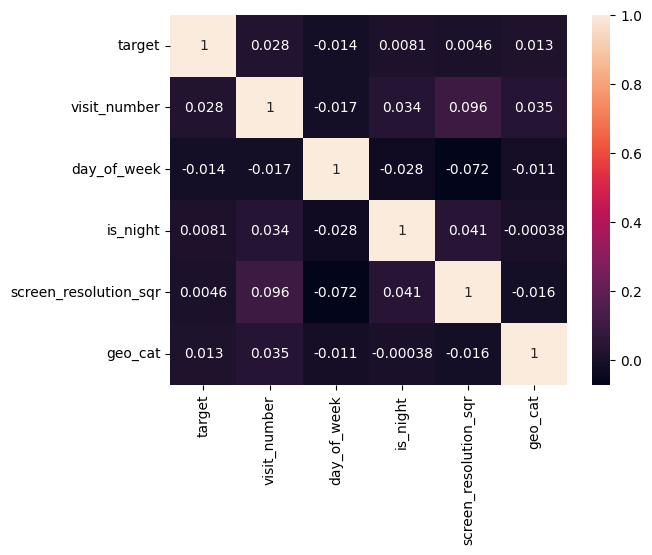

In [65]:
sns.heatmap(df.corr(), annot = True)

#Modeling

In [18]:
df_1 = df[df.target == 1]
df_0 = df[df.target == 0]
df_0 = df_0.iloc[:50314]
df_balanced = pd.concat([df_1, df_0], axis=0)
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

In [14]:
df_balanced.columns

Index(['session_id', 'target', 'visit_number', 'utm_source', 'utm_medium',
       'utm_campaign', 'utm_adcontent', 'device_category', 'device_brand',
       'device_browser', 'day_of_week', 'is_night', 'screen_resolution_sqr',
       'geo_cat'],
      dtype='object')

In [23]:
categorical_features = df_balanced[['utm_source', 'utm_medium','utm_campaign',
                           'utm_adcontent', 'device_category',
                           'device_brand', 'device_browser']]

numerucal_features = df_balanced[['visit_number', 'day_of_week', 'is_night',
                                  'screen_resolution_sqr', 'geo_cat']]

columns_for_drop = ['session_id', 'utm_source', 'utm_medium','utm_campaign',
                    'utm_adcontent', 'device_category', 'device_brand',
                    'device_browser', 'visit_number', 'day_of_week', 'is_night',
                    'screen_resolution_sqr', 'geo_cat']

In [21]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(categorical_features)
ohe_data = ohe.transform(categorical_features)
df_balanced[ohe.get_feature_names_out()] = ohe_data

<ipython-input-21-ce7b9c8182f9>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_balanced[ohe.get_feature_names_out()] = ohe_data
<ipython-input-21-ce7b9c8182f9>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_balanced[ohe.get_feature_names_out()] = ohe_data
<ipython-input-21-ce7b9c8182f9>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-frag

In [25]:
std_scaler = StandardScaler()
std_scaler.fit(numerucal_features)
std_scaler_data = std_scaler.transform(numerucal_features)
df_balanced[['visit_number_std', 'day_of_week_std', 'is_night_std',
             'screen_resolution_sqr_std', 'geo_cat_std']] = std_scaler_data

In [27]:
df_balanced = df_balanced.drop(columns=columns_for_drop)

In [30]:
logreg = LogisticRegression(solver='liblinear', max_iter=200, C=3.0)

In [33]:
x = df_balanced.drop(['target'], axis=1)
y = df_balanced.target
score = cross_val_score(logreg, x, y, cv=4, scoring='roc_auc')
print(score)

[0.67688988 0.68000365 0.6713473  0.67586059]


In [34]:
logreg.fit(x, y)

LogisticRegression(C=3.0, max_iter=200, solver='liblinear')

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [40]:
logreg.fit(x_train, y_train)

LogisticRegression(C=3.0, max_iter=200, solver='liblinear')

In [41]:
predict = logreg.predict(x_test)

In [45]:
confusion_matrix(y_test, predict)

array([[ 7926,  7243],
       [ 4077, 10943]])